# Assess MODIS error

In [18]:
# imports
from importlib import reload
from importlib.resources import files
import os
import numpy as np

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.interpolate import interp1d

from oceancolor.hydrolight import loisel23

from big.models import anw as big_anw
from big.models import bbnw as big_bbnw
from big import inference as big_inf
from big import rt as big_rt
from big import chisq_fit
from big import plotting

In [19]:
%matplotlib ipympl

# Load MODIS

## Generated here:

## https://seabass.gsfc.nasa.gov/search/?search_type=Perform%20Validation%20Search&val_sata=1&val_products=11&val_source=0

In [10]:
modis_file = os.path.join(files('big'), 'data', 'MODIS', 'MODIS_matchups_rrs.csv')
modis = pandas.read_csv(modis_file, comment='#')

In [11]:
modis.head()

,fields=id,latitude,longitude,date_time,cruise,aqua_filename,aqua_es_error,aqua_pixel_total,aqua_tdiff,aqua_solz,...,aqua_rrs678,insitu_rrs412,insitu_rrs443,insitu_rrs488,insitu_rrs531,insitu_rrs547,insitu_rrs555,insitu_rrs667,insitu_rrs678,insitu_data_source
0,1356,22.750,-158.000,2002-08-29 23:11:00,hot-139,A2002241232000.L2_LAC.R0000018899_22N_22N_158W...,2.20,25,710,18.13,...,0.000218,0.012546,0.009029,0.005874,-999.000000,-999.0,0.001391,0.000052,-999.0,seabass
1,1358,22.750,-158.000,2002-11-04 22:09:00,hot-141,A2002308235000.L2_LAC.R0000018901_22N_22N_158W...,6.55,25,6231,45.09,...,0.000160,0.013288,0.009640,0.006700,-999.000000,-999.0,0.001737,0.000139,-999.0,seabass
2,1562,32.347,-118.565,2002-11-11 18:30:00,cal0211,A2002315204000.L2_LAC.R0000018739_32N_32N_118W...,16.85,25,8021,52.30,...,0.000223,0.003724,-999.000000,-999.000000,0.001876,-999.0,0.001379,0.000086,-999.0,seabass
3,1563,31.187,-120.917,2002-11-12 19:20:00,cal0211,A2002316212500.L2_LAC.R0000018739_31N_30N_121W...,8.30,25,7574,54.41,...,0.000245,0.006243,0.006394,0.005534,0.002664,-999.0,0.001974,0.000093,-999.0,seabass
4,1566,33.430,-117.913,2002-11-16 18:20:00,cal0211,A2002320210000.L2_LAC.R0000018739_33N_33N_117W...,12.20,25,9746,56.16,...,0.000102,0.004791,0.004507,0.004409,0.002424,-999.0,0.001789,0.000117,-999.0,seabass


In [12]:
modis.keys()

Index(['fields=id', 'latitude', 'longitude', 'date_time', 'cruise',
       'aqua_filename', 'aqua_es_error', 'aqua_pixel_total', 'aqua_tdiff',
       'aqua_solz', 'aqua_senz', 'aqua_cv', 'aqua_windspeed', 'aqua_rrs412',
       'aqua_rrs443', 'aqua_rrs488', 'aqua_rrs531', 'aqua_rrs547',
       'aqua_rrs555', 'aqua_rrs667', 'aqua_rrs678', 'insitu_rrs412',
       'insitu_rrs443', 'insitu_rrs488', 'insitu_rrs531', 'insitu_rrs547',
       'insitu_rrs555', 'insitu_rrs667', 'insitu_rrs678',
       'insitu_data_source'],
      dtype='object')

# Calc stats

In [13]:
wv = 412

In [45]:
def calc_stats(modis, wv):
    diff = modis[f'aqua_rrs{wv}'] - modis[f'insitu_rrs{wv}']
    cut = (np.abs(diff) < 100.) & np.isfinite(modis[f'aqua_rrs{wv}']) & (modis[f'aqua_rrs{wv}'] > 0.)
    std = np.std(diff[cut])
    rel_std = np.std(np.abs(diff[cut])/modis[f'aqua_rrs{wv}'][cut])
    # Return
    return diff, cut, std, rel_std

In [48]:
for wv in [412, 443, 488, 531, 547, 555, 667, 678]:
    diff, cut, std, rel_std = calc_stats(modis, wv)
    #
    print(f'wv: {wv}, std={std:0.5f} sr^-1, rel_std={rel_std:0.2f}%')

wv: 412, std=0.00141 sr^-1, rel_std=10.88%
wv: 443, std=0.00113 sr^-1, rel_std=9.36%
wv: 488, std=0.00113 sr^-1, rel_std=0.68%
wv: 531, std=0.00102 sr^-1, rel_std=0.19%
wv: 547, std=0.00117 sr^-1, rel_std=0.19%
wv: 555, std=0.00120 sr^-1, rel_std=0.22%
wv: 667, std=0.00056 sr^-1, rel_std=6.22%
wv: 678, std=0.00060 sr^-1, rel_std=4.15%


# Plots

## Histogram

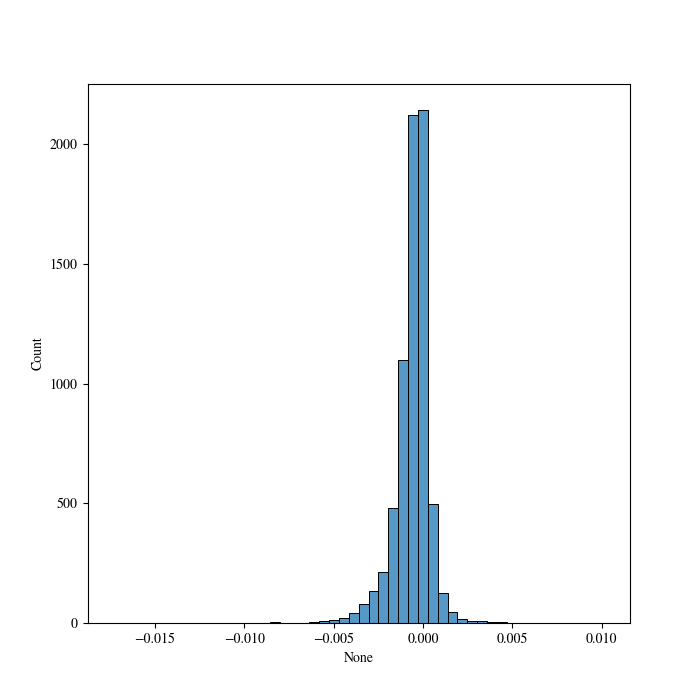

In [59]:
wv = 531
diff, cut, std, rel_std = calc_stats(modis, wv)
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
sns.histplot(x=diff[cut], bins=50, ax=ax)
plt.show()

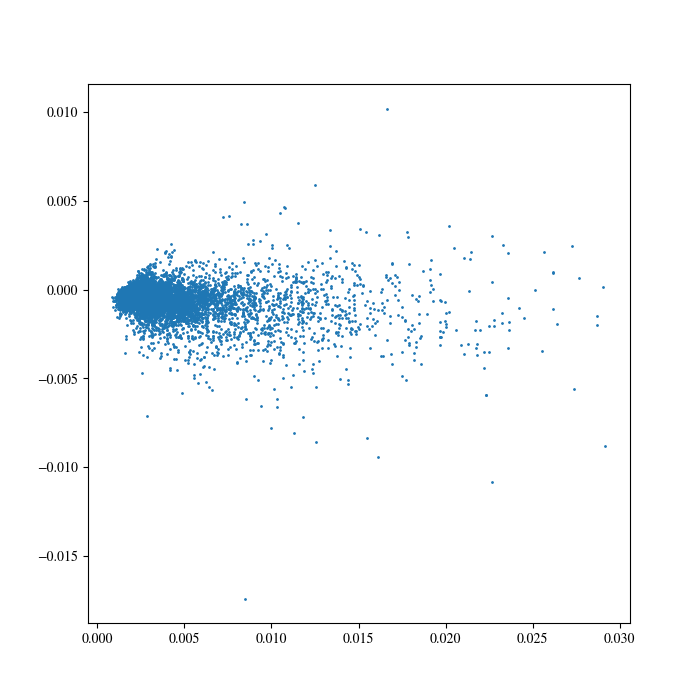

In [60]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
#
ax.plot(modis[f'aqua_rrs{wv}'][cut], diff[cut], 'o', ms=1.)
#
plt.show()

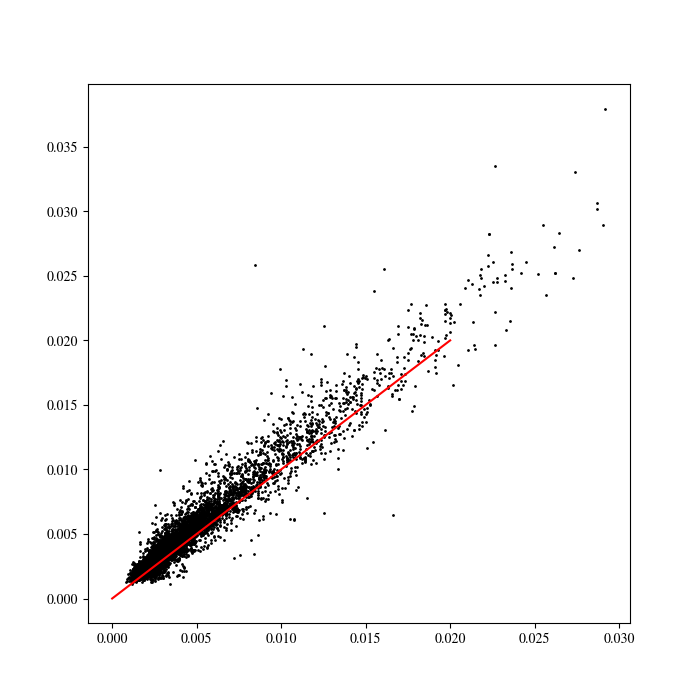

In [61]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
#
ax.plot(modis[f'aqua_rrs{wv}'][cut], modis[f'insitu_rrs{wv}'][cut], 'ko', ms=1.)
ax.plot([0., 0.02], [0., 0.02], 'r-')
#
plt.show()